## |V - Modélisation en Régression Logistique

In [23]:
import pandas as pd
import mlflow
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder , StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, mean_squared_error, r2_score
from sklearn.metrics import roc_curve, roc_auc_score

In [24]:
df = pd.read_csv("../data/gold.csv")
df.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,...,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,nb-service
0,Female,No,Yes,No,1,No,No phone service,DSL,No,Yes,...,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No,1
1,Male,No,No,No,34,Yes,No,DSL,Yes,No,...,No,No,No,One year,No,Mailed check,56.95,1889.50,No,2
2,Male,No,No,No,2,Yes,No,DSL,Yes,Yes,...,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes,2
3,Male,No,No,No,45,No,No phone service,DSL,Yes,No,...,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No,3
4,Female,No,No,No,2,Yes,No,Fiber optic,No,No,...,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes,0


In [25]:
df = df.drop(columns=['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies'], axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7043 non-null   object 
 1   SeniorCitizen     7043 non-null   object 
 2   Partner           7043 non-null   object 
 3   Dependents        7043 non-null   object 
 4   tenure            7043 non-null   int64  
 5   PhoneService      7043 non-null   object 
 6   MultipleLines     7043 non-null   object 
 7   InternetService   7043 non-null   object 
 8   Contract          7043 non-null   object 
 9   PaperlessBilling  7043 non-null   object 
 10  PaymentMethod     7043 non-null   object 
 11  MonthlyCharges    7043 non-null   float64
 12  TotalCharges      7043 non-null   float64
 13  Churn             7043 non-null   object 
 14  nb-service        7043 non-null   int64  
dtypes: float64(2), int64(2), object(11)
memory usage: 825.5+ KB


In [26]:
df.columns


Index(['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure',
       'PhoneService', 'MultipleLines', 'InternetService', 'Contract',
       'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges', 'TotalCharges',
       'Churn', 'nb-service'],
      dtype='object')

In [27]:
X = df.drop('Churn', axis=1)
y = df['Churn']
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, shuffle=False, random_state=42)

In [28]:
labelencoder = LabelEncoder()
y_train =  labelencoder.fit_transform(y_train)
y_test = labelencoder.transform(y_test)

In [29]:
categorial_features = ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'MultipleLines', 'InternetService',
        'Contract', 'PaperlessBilling', 'PaymentMethod','PhoneService'
       ]

numerical_features = list(X.select_dtypes(include=[int,float]).columns)

categorical_transformer = OneHotEncoder(sparse=True)

numerical_transformer = StandardScaler()

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorial_features),
        ('num', numerical_transformer, numerical_features)
    ]
)

log_reg = LogisticRegression(penalty='l2', C=0.01)

pipe = Pipeline([
     ('preprocessor', preprocessor),
     ('log_reg', log_reg)
])

pipe

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(sparse=True),
                                                  ['gender', 'SeniorCitizen',
                                                   'Partner', 'Dependents',
                                                   'MultipleLines',
                                                   'InternetService',
                                                   'Contract',
                                                   'PaperlessBilling',
                                                   'PaymentMethod',
                                                   'PhoneService']),
                                                 ('num', StandardScaler(),
                                                  ['tenure', 'MonthlyCharges',
                                                   'TotalCharges',
                                                   'nb-service'])])),
                ('log_reg', LogisticRegression(C=0.01))])

In [30]:
pipe.fit(X_train, y_train)
y_pred_train = pipe.predict(X_train)
y_pred_test = pipe.predict(X_test)

/home/apprenant/miniconda3/envs/sklearn-env/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [31]:
experiment_id = mlflow.set_experiment("churn_model").experiment_id

run_name = "nbservice_regLogistique(C=0.1)"

with mlflow.start_run(experiment_id=experiment_id, run_name=run_name) as run:
    # Log the baseline model to MLflow
    pipe.fit(X_train, y_train)
      
    mlflow.sklearn.log_model(pipe, "reglog_nbservice")

    
    model_uri = mlflow.get_artifact_uri("reglog_nbservice")


    # Log des Tags
    mlflow.log_param("C", log_reg.C)
    mlflow.set_tag("model","logistic_regression")
    mlflow.set_tag("regularisation",True)

    eval_data = X_test
    eval_data["label"] = y_test
    y_pred = pipe.predict(X_test)

   
    f1 = f1_score(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)

    # journaliser les métriques
    mlflow.log_metric("f1", f1)
    mlflow.log_metric("accuracy", accuracy)
    mlflow.log_metric("roc_auc", roc_auc)
    mlflow.log_metric("recall", recall)
    mlflow.log_metric("r2", r2)
    mlflow.log_metric("mse", mse)

/home/apprenant/miniconda3/envs/sklearn-env/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [32]:
print("######## accuracy_score : ")
print("TRAIN :",accuracy_score(y_train, y_pred_train))
print("TEST :",accuracy_score(y_test, y_pred_test))

print("######## precision_score : ")
print("TRAIN :",precision_score(y_train, y_pred_train))
print("TEST :",precision_score(y_test, y_pred_test))

print("######## recall_score : ")    
print("TRAIN :",recall_score(y_train, y_pred_train))
print("TEST :",recall_score(y_test, y_pred_test))

print("######## f1_score : ")
print("TRAIN :",f1_score(y_train, y_pred_train))
print("TEST :",f1_score(y_test, y_pred_test))

######## accuracy_score : 
TRAIN : 0.8015619453319134
TEST : 0.794889992902768
######## precision_score : 
TRAIN : 0.6706642066420664
TEST : 0.676923076923077
######## recall_score : 
TRAIN : 0.4885752688172043
TEST : 0.46194225721784776
######## f1_score : 
TRAIN : 0.5653188180404355
TEST : 0.5491419656786272


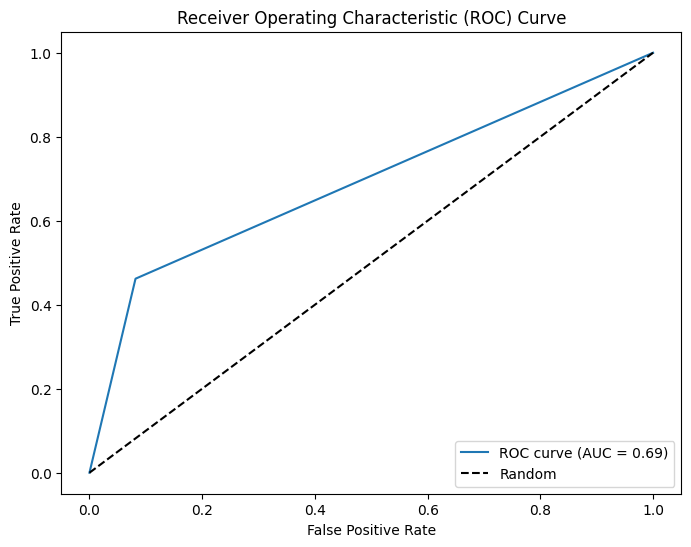

######## roc_auc_score : 
TRAIN : 0.701234088822495
TEST : 0.6901150974805191


In [33]:

# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_test)

# Calculate the area under the ROC curve (AUC)
auc = roc_auc_score(y_test, y_pred_test)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='ROC curve (AUC = {:.2f})'.format(auc))
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

print("######## roc_auc_score : ")    
print("TRAIN :",roc_auc_score(y_train, y_pred_train))
print("TEST :",roc_auc_score(y_test, y_pred_test))  